# Exploration of Retinal Cells with AngioTool

### Load data
We need to combine the genotype info with the AngioTool data.


Start by loading the Excel spreadsheet with select columns (we don't care about the date, time, etc.) into a `pandas` DataFrame. 

In [1]:
import numpy as np
import pandas as pd

#tweaked_results = './processed/tweaked/TweakedResults11-6-2017.xls'
tweaked_results = './data/TweakedResults2017-12-4.xls'
data = pd.read_excel(tweaked_results,
                     usecols = "A, G, N, O, Q, S")
# These are the Excel columns that correspond to 
# the desired AngioTool output parameters

pd.options.display.float_format = '{:,.2f}'.format

Confirm you loaded the correct thing by looking at the header. You can always look at a Dataframe's header through `df.head()`

In [2]:
data.head()

,Image Name,Vessel Thickness,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
0,35-3b-field 1.tif,9,65.03,119,14.22,16
1,35-3b-field 2.tif,9,61.50,183,16.88,17
2,35-3b-field 3.tif,9,55.25,157,15.50,29
3,35-5b-field 1.tif,10,55.22,138,14.47,37
4,35-5-field 2.tif,9,51.73,134,13.18,32


### Create unique IDs for each animal
We need to parse the Image Name column in order to get a unique ID for each animal. The unique ID will be used for pairing genotypes using the Genotyping Key document.

I'm using list comprehensions to get Litter/ID info from the Image Name. Both are added to our `data` DataFrame.

In [3]:
data['Litter'] =   [x[:2] for x in data['Image Name']]
data['AnimalID'] = [x[:4] for x in data['Image Name']]

### Load genotyping key
Once again, we'll use the `read_excel` tool found within the `pandas` library.

In [4]:
key = pd.read_excel('./data/genotypingkey.xlsx')
#key

### Obtain entire dataset
We'll merge the two dataframes by using the `merge` function from the `pandas` library. Notice how `AnimalID` is used to match.

We can also drop unneeded columns such as `Image Name`, `ID`, and the duplicated `Litter_y`.

In [5]:
merged_inner = pd.merge(left = data, right = key,
                        how = 'inner',
                        left_on =  'AnimalID',
                        right_on = 'AnimalID'
                       )
## Drop unneeded columns
merged_inner.drop('Litter_y',         axis = 1, inplace = True)
merged_inner.drop('ID',               axis = 1, inplace = True)
merged_inner.drop('Image Name',       axis = 1, inplace = True)
merged_inner.drop('Vessel Thickness', axis = 1, inplace = True)

merged_inner.rename(columns = {'Litter_x':'Litter'},
                    inplace = True)

pd.options.display.float_format = '{:,.2f}'.format

## Show first five observations
merged_inner.head()

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points,Litter,AnimalID,Genotype
0,65.03,119,14.22,16,35,35-3,+/+
1,61.50,183,16.88,17,35,35-3,+/+
2,55.25,157,15.50,29,35,35-3,+/+
3,55.22,138,14.47,37,35,35-5,DEE/DEE
4,51.73,134,13.18,32,35,35-5,DEE/DEE


### Average over Litter and Genotype
Now that we have unblinded our data by assigning genotypes to the various animals, let's pivot by `Genotype` and `Litter` using `set_index()`.

We can also use `sort_index()` to make sure the genotype ordering is consistent for all litters.

Once grouped, we can calculate mean values.

In [6]:
data_mean = (merged_inner
             .set_index(['Litter', 'Genotype']) # pivot
             .sort_index(level = ['Litter', 'Genotype'])
             .mean(level = ['Litter', 'Genotype'])
            )
data_mean

Vessels percentage area  Total Number of Junctions  \
Litter Genotype                                                       
35     +/+                         60.59                     153.00   
       DEE/DEE                     53.62                     132.33   
36     +/+                         64.30                     171.67   
       DEE/DEE                     62.15                     136.83   
37     +/+                         58.68                     110.00   
       DEE/+                       61.73                     161.00   
       DEE/DEE                     54.29                      98.33   
40     +/+                         55.96                     177.00   
       DEE/+                       51.47                     111.25   
       DEE/DEE                     51.08                     116.40   
41     +/+                         49.74                     106.20   
       DEE/DEE                     49.87                      91.33   

                 Total Vessels Length  Total Number of End Points  
Litter Genotype                                                    
35     +/+                      15.53                       20.67  
       DEE/DEE                  13.57                       38.67  
36     +/+                      16.09                       26.33  
       DEE/DEE                  14.42                       31.17  
37     +/+                      13.10                       25.33  
       DEE/+                    15.67                       32.50  
       DEE/DEE                  12.67                       27.67  
40     +/+                      16.09                       46.83  
       DEE/+                    12.85                       32.25  
       DEE/DEE                  13.23                       34.20  
41     +/+                      11.68                       39.80  
       DEE/DEE                  11.32                       40.67

### Split data

`data_mean` is a `MultiIndex` object instead of your usual `DataFrame`

In [7]:
data_mean.index

MultiIndex(levels=[['35', '36', '37', '40', '41'], ['+/+', 'DEE/+', 'DEE/DEE']],
           labels=[[0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 4, 4], [0, 2, 0, 2, 0, 1, 2, 0, 1, 2, 0, 2]],
           names=['Litter', 'Genotype'])

We will use `panda`'s cross-section function, `DataFrame.xs`, to separate our data by genotype.

| Wild type | Mutant  |
|-----------|---------|
| +/+       | DEE/DEE |

In [8]:
wild =   data_mean.xs('+/+',     level = 'Genotype')
mutant = data_mean.xs('DEE/DEE', level = 'Genotype')

In [9]:
## Get parameter data arrays
wildVPA =           wild['Vessels percentage area'].values
wildNJunctions =    wild['Total Number of Junctions'].values
wildVesselsLength = wild['Total Vessels Length'].values
wildNEndPoints =    wild['Total Number of End Points'].values

mutantVPA =           mutant['Vessels percentage area'].values
mutantNJunctions =    mutant['Total Number of Junctions'].values
mutantVesselsLength = mutant['Total Vessels Length'].values
mutantNEndPoints =    mutant['Total Number of End Points'].values

## Hypothesis testing

Now that we have our data ready to go, we can do a **paired t-test**.

`scipy` contains useful things for scientific analysis, and they have a built-in paired t-test function called `ttest_rel`.

In [10]:
from scipy import stats

## Do paired/dependent t-tests
t_VPA, p_VPA = stats.ttest_rel(wildVPA, mutantVPA)

t_n_junct, p_n_junct = stats.ttest_rel(
    wildNJunctions, mutantNJunctions)

t_vessel_length, p_vessel_length = stats.ttest_rel(
    wildVesselsLength, mutantVesselsLength)

t_n_endpoints, p_n_endpoints = stats.ttest_rel(
    wildNEndPoints, mutantNEndPoints)

t_statistics = [t_VPA, t_n_junct, t_vessel_length, t_n_endpoints]
p_values =     [p_VPA, p_n_junct, p_vessel_length, p_n_endpoints]

stat_df = pd.DataFrame({'Parameter': wild.columns,
                        't_statistic': t_statistics, 
                        'p_value': p_values})

stat_df.set_index('Parameter')

,p_value,t_statistic
Parameter,,
Vessels percentage area,0.04,3.00
Total Number of Junctions,0.03,3.19
Total Vessels Length,0.04,3.07
Total Number of End Points,0.61,-0.55


It appears that our p-values for 
- `Vessels percentage area` 
- `Total Number of Junctions`
- `Total Vessels Length`

are statistically significant at the p < 0.05 level.

However, p-values by themselves aren't very useful. Sure, there's indication of a statistically significant result, but what sort of a difference does it make?

To answer this, we can look at **effect size**.

"Cohen's d" is frequently seen among literature, but there are a handful of techniques that are mistakenly attributed to be Cohen's d. For a good review, I recommend https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/.

In this analysis, we will use Cohen's $d_z$, where the $z$ reminds us that we are looking at the difference of two samples ($x$ and $y$).



In [11]:
## Calculate Cohen's d using test statistic and n
## https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3840331/
def get_cohens_d_z(t_statistic, n):
    """Returns Cohen's d_z
    
    One way of calculating Cohen's d is by 
    taking the t-statistic and dividing it by
    the square root of the sample size.
    """
    d = [t / np.sqrt(n)
         for t in t_statistic]
    
    return d

n = len(wildVPA)
cohens_d_values = get_cohens_d_z(t_statistics, n)

pd.options.display.float_format = '{:,.3f}'.format

stat_df['cohen_dz'] = cohens_d_values
stat_df.set_index('Parameter')

,p_value,t_statistic,cohen_dz
Parameter,,,
Vessels percentage area,0.040,3.004,1.343
Total Number of Junctions,0.033,3.188,1.426
Total Vessels Length,0.037,3.073,1.374
Total Number of End Points,0.612,-0.549,-0.245


## Effect size results
The Cohen d$_z$ values indicate that our effect sizes are on the order of 1.4$\sigma$.

There's some concern that Cohen's d is biased upwards for small samples (n < 20)

For fun, we can calculate cohen's $d$ using means and stds. We expect calculating the effect size from the t-statistic to yield identical results.

In [12]:
pd.options.display.float_format = '{:,.2f}'.format

## Look at the difference in means
diff = wild - mutant
diff

,Vessels percentage area,Total Number of Junctions,Total Vessels Length,Total Number of End Points
Litter,,,,
35,6.97,20.67,1.96,-18.00
36,2.15,34.83,1.67,-4.83
37,4.39,11.67,0.44,-2.33
40,4.87,60.60,2.85,12.63
41,-0.12,14.87,0.36,-0.87


In [13]:
means = diff.mean()
means

Vessels percentage area       3.65
Total Number of Junctions    28.53
Total Vessels Length          1.46
Total Number of End Points   -2.68
dtype: float64

In [14]:
stds = diff.std()
stds

Vessels percentage area       2.72
Total Number of Junctions    20.01
Total Vessels Length          1.06
Total Number of End Points   10.92
dtype: float64

In [15]:
means/stds

Vessels percentage area       1.34
Total Number of Junctions     1.43
Total Vessels Length          1.37
Total Number of End Points   -0.25
dtype: float64

## Boxplots for different parameters

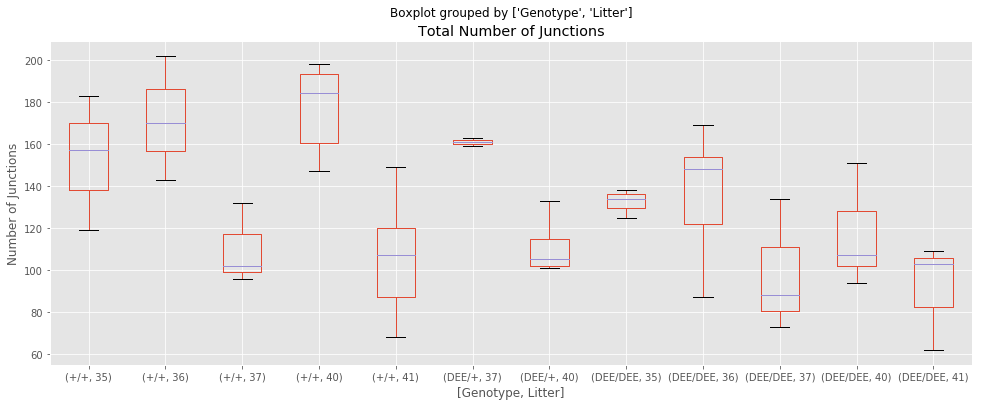

In [16]:
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

merged_inner.boxplot(column = ['Total Number of Junctions'],
                     #by = ['Litter', 'Genotype'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Number of Junctions')
plt.show()

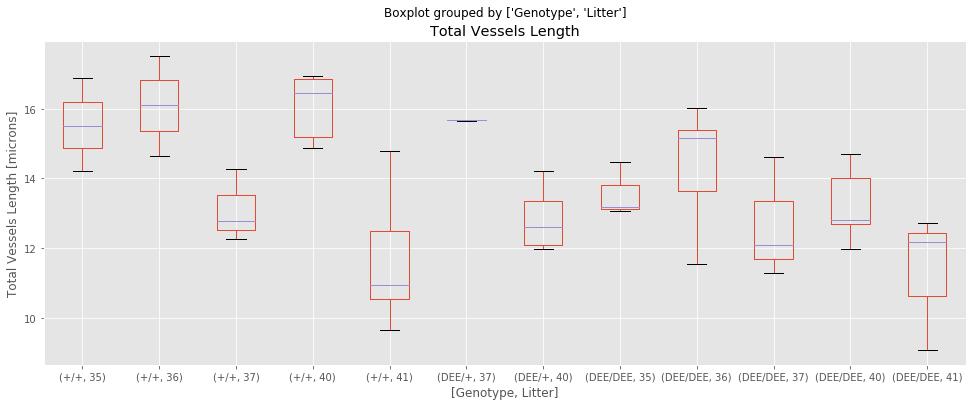

In [17]:
merged_inner.boxplot(column = ['Total Vessels Length'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Total Vessels Length [microns]')
plt.show()

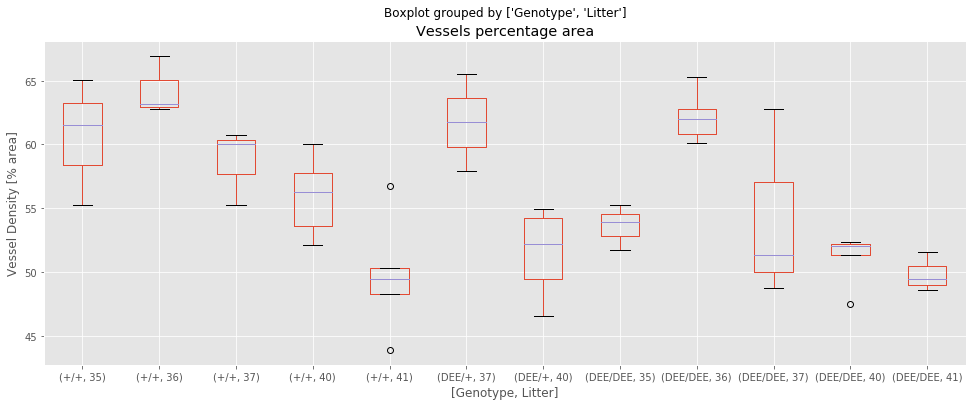

In [18]:
merged_inner.boxplot(column = ['Vessels percentage area'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Vessel Density [% area]')
plt.show()

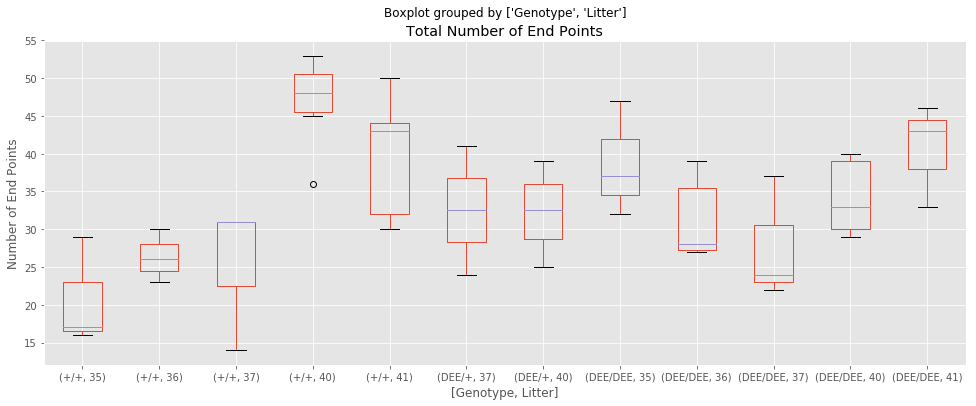

In [19]:
merged_inner.boxplot(column = ['Total Number of End Points'],
                     by = ['Genotype', 'Litter'],
                     figsize = (16,6)
                    )
plt.ylabel('Number of End Points')
plt.show()

## Comparison in Percentages

The below table represents mutant values normalized to wild type in percentage.

In [20]:
normdata = ((mutant / wild.values * 100)
            .rename(
                columns={
                    'Vessels percentage area':'norm Vessels Density',
                    'Total Number of Junctions':'norm Number of Junctions',
                    'Total Vessels Length':'norm Vessels Length',
                    'Total Number of End Points':'norm Number of End Points'}
                    )
            )

#normdata.drop('Genotype', axis=0, level=1, inplace=True)
#normdata.drop('Vessel Thickness', axis=0, level=1,inplace=True)
#normdata[['norm Vessels Density','norm Number of Junctions', 'norm Vessels Length', 'norm Number of End Points']]
pd.options.display.float_format = '{:,.2f}'.format
normdata



,norm Vessels Density,norm Number of Junctions,norm Vessels Length,norm Number of End Points
Litter,,,,
35,88.49,86.49,87.36,187.10
36,96.66,79.71,89.62,118.35
37,92.52,89.39,96.67,109.21
40,91.29,65.76,82.27,73.02
41,100.24,86.00,96.92,102.18


## Mean and std for different variables in different litters

If you want to look at the numbers after averaging, here they are.

In [21]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Number of End Points']
                     .describe()
)

count  mean   std   min   25%   50%   75%   max
Litter Genotype                                                 
35     +/+        3.00 20.67  7.23 16.00 16.50 17.00 23.00 29.00
       DEE/DEE    3.00 38.67  7.64 32.00 34.50 37.00 42.00 47.00
36     +/+        3.00 26.33  3.51 23.00 24.50 26.00 28.00 30.00
       DEE/DEE    6.00 31.17  5.71 27.00 27.25 28.00 35.50 39.00
37     +/+        3.00 25.33  9.81 14.00 22.50 31.00 31.00 31.00
       DEE/+      2.00 32.50 12.02 24.00 28.25 32.50 36.75 41.00
       DEE/DEE    3.00 27.67  8.14 22.00 23.00 24.00 30.50 37.00
40     +/+        6.00 46.83  6.01 36.00 45.50 48.00 50.50 53.00
       DEE/+      4.00 32.25  6.08 25.00 28.75 32.50 36.00 39.00
       DEE/DEE    5.00 34.20  5.07 29.00 30.00 33.00 39.00 40.00
41     +/+        5.00 39.80  8.50 30.00 32.00 43.00 44.00 50.00
       DEE/DEE    3.00 40.67  6.81 33.00 38.00 43.00 44.50 46.00

In [22]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Vessels percentage area']
                     .describe()
)

count  mean  std   min   25%   50%   75%   max
Litter Genotype                                                
35     +/+        3.00 60.59 4.96 55.25 58.37 61.50 63.27 65.03
       DEE/DEE    3.00 53.62 1.76 51.73 52.82 53.91 54.56 55.22
36     +/+        3.00 64.30 2.31 62.81 62.97 63.13 65.04 66.96
       DEE/DEE    6.00 62.15 1.86 60.14 60.83 61.98 62.81 65.27
37     +/+        3.00 58.68 2.96 55.29 57.66 60.02 60.38 60.73
       DEE/+      2.00 61.73 5.38 57.92 59.83 61.73 63.63 65.54
       DEE/DEE    3.00 54.29 7.47 48.76 50.04 51.32 57.06 62.79
40     +/+        6.00 55.96 3.04 52.12 53.63 56.27 57.76 60.07
       DEE/+      4.00 51.47 3.82 46.53 49.46 52.22 54.23 54.94
       DEE/DEE    5.00 51.08 2.04 47.50 51.34 52.04 52.18 52.35
41     +/+        5.00 49.74 4.64 43.90 48.30 49.42 50.33 56.77
       DEE/DEE    3.00 49.87 1.52 48.60 49.02 49.45 50.50 51.55

In [23]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Number of Junctions']
                     .describe()
)

count   mean   std    min    25%    50%    75%    max
Litter Genotype                                                       
35     +/+        3.00 153.00 32.19 119.00 138.00 157.00 170.00 183.00
       DEE/DEE    3.00 132.33  6.66 125.00 129.50 134.00 136.00 138.00
36     +/+        3.00 171.67 29.54 143.00 156.50 170.00 186.00 202.00
       DEE/DEE    6.00 136.83 30.67  87.00 121.75 148.00 154.00 169.00
37     +/+        3.00 110.00 19.29  96.00  99.00 102.00 117.00 132.00
       DEE/+      2.00 161.00  2.83 159.00 160.00 161.00 162.00 163.00
       DEE/DEE    3.00  98.33 31.79  73.00  80.50  88.00 111.00 134.00
40     +/+        6.00 177.00 21.49 147.00 160.50 184.00 193.25 198.00
       DEE/+      4.00 111.25 14.93 101.00 101.75 105.50 115.00 133.00
       DEE/DEE    5.00 116.40 23.07  94.00 102.00 107.00 128.00 151.00
41     +/+        5.00 106.20 31.03  68.00  87.00 107.00 120.00 149.00
       DEE/DEE    3.00  91.33 25.58  62.00  82.50 103.00 106.00 109.00

In [24]:
(merged_inner.groupby(['Litter', 'Genotype'])
                     ['Total Vessels Length']
                     .describe()
)

count  mean  std   min   25%   50%   75%   max
Litter Genotype                                                
35     +/+        3.00 15.53 1.33 14.22 14.86 15.50 16.19 16.88
       DEE/DEE    3.00 13.57 0.78 13.06 13.12 13.18 13.82 14.47
36     +/+        3.00 16.09 1.44 14.64 15.37 16.09 16.81 17.52
       DEE/DEE    6.00 14.42 1.71 11.54 13.64 15.17 15.40 16.01
37     +/+        3.00 13.10 1.05 12.26 12.52 12.77 13.52 14.28
       DEE/+      2.00 15.67 0.02 15.66 15.67 15.67 15.68 15.69
       DEE/DEE    3.00 12.67 1.74 11.29 11.69 12.08 13.35 14.62
40     +/+        6.00 16.09 0.98 14.88 15.20 16.46 16.86 16.95
       DEE/+      4.00 12.85 1.03 11.96 12.10 12.61 13.36 14.21
       DEE/DEE    5.00 13.23 1.09 11.99 12.70 12.79 14.01 14.69
41     +/+        5.00 11.68 2.02  9.64 10.55 10.94 12.50 14.78
       DEE/DEE    3.00 11.32 1.96  9.08 10.63 12.18 12.45 12.71

In [25]:
# Potentially useful snippets for the future

In [26]:
# Remove heterozygous data
# We are comparing wild type and mutant.
# To make things easier later, let's now remove 
# the heterozygous data using string matching with regular expressions.

# + is a special character. must prepend with \
#het_regex = "DEE/\+" 

#merged_inner = merged_inner[~merged_inner['Genotype']
#                            .str.match(het_regex)]

In [27]:
#idx = pd.IndexSlice
#data_mean.index

In [28]:
# equivalent to data_mean.query('Genotype == "+/+"')
#data_mean.loc[idx[:,'+/+'],:]  

In [29]:
#diffdata = ((wild.values - mutant)
#            .rename(
#                columns={
#                    'Vessels percentage area':'diff Vessels percentage area',
#                    'Total Number of Junctions':'diff Number of Junctions',
#                    'Total Vessels Length':'diff Vessels Length',
#                    'Total Number of End Points':'diff Number of End Point'}
#                    )
#            )


#diffdata

In [30]:
#diffdata['diff Vessels percentage area'].hist()
#plt.show()

In [31]:
#diffdata['diff Number of Junctions'].hist()
#plt.show()

In [32]:
#diffdata['diff Number of End Point'].hist()


In [33]:
#diffdata['diff Vessels Length'].hist()
#plt.show()

In [34]:
#
#def get_unbiased_d(cohens_d, n):
#    """Returns an unbiased estimator of effect size
#    
#    Cohen's d is biased upwards for small sample size.
#    Hedges and Olkin (1985) suggested a correction to
#    Cohen's d.
#    """
#    d_unbiased = [d * (1 - 3/(4*(n - 2) - 1))
#                 for d in cohens_d]
#    
#    return d_unbiased

#def other_d(t_statistic, n):
#    other_d = [2*t / np.sqrt(n-2)
#              for t in t_statistic]
    
#    return other_d

#def another_d(t_statistic, n):
#    another_d = [np.sqrt(2) * t / np.sqrt(n-1)
#                for t in t_statistic]
    
#    return another_d

#print(other_d(t_statistics, n))


#unbiashed_d_values = get_unbiased_d(cohens_d_values, n)
#other_d_values = other_d(t_statistics, n)
#another_d_values = another_d(t_statistics, n)

#rounded_cohens = list(map(lambda x: np.round(x,1), cohens_d_values))
#print('cohens d:')
#print(cohens_d_values)
#print(["{:f}".format([print(d) for d in cohens_d_values])])
#print('unbiased d:')
#print(unbiashed_d_values)
#print('other d:')
#print(other_d_values)
#print('another d:')
#print(another_d_values)

In [35]:
##from scipy import stats
#import statsmodels.api as sm

#wild_data = [wildVPA, wildNJunctions, wildVesselsLength]
#mutant_data = [mutantVPA, mutantNJunctions, mutantVesselsLength]
#
#plt.close()
#fig, axes = plt.subplots(2, 3, figsize=(10,10),sharex=True)
#ax = axes.ravel()
#for i, (wild_var, mutant_var) in enumerate(
#    list(zip(wild_data, mutant_data))):
    
#    sm.graphics.qqplot(data=wild_var, ax=ax[i])
#    sm.graphics.qqplot(data=mutant_var, ax=ax[i+3])
#stats.probplot(wildVPA, plot=ax[0])
#plt.show()